In [1]:
import sys, os 
sys.path.append("..") 

In [2]:
import pfb 
import numpy as np 
from constants import SINC,LBLOCK,NTAP 
from numpy.fft import fft,rfft,ifft,irfft 
import matplotlib.pyplot as plt 

In [8]:
def A(x): 
    b = pfb.forward_pfb(x) 
    b = irfft(b) 
    b = np.concatenate([b , b[:3,:]],axis=0) 
    return b.flatten() 

def A_inv(b_flat,lblock=LBLOCK): 
    if len(b_flat)/lblock != len(b_flat)//lblock: raise Exception("the dimensions of the input does not match lblock:\n\
        {} should be an integer".format(len(b_flat)/lblock)) 
    b = np.array([b_flat[i*lblock:(i+1)*lblock] for i in range(k-3)]) # -3 drops the last three rows
    b = rfft(b) 
    return pfb.inverse_pfb(b) 

def A_inv_weiner(b_flat,lblock=LBLOCK):
    if len(b_flat)/lblock != len(b_flat)//lblock: raise Exception("the dimensions of the input does not match lblock:\n\
        {} should be an integer".format(len(b_flat)/lblock))
    b = np.array([b_flat[i*lblock:(i+1)*lblock] for i in range(k-3)]) # -3 drops the last three rows
    b = rfft(b)
    return pfb.inverse_pfb(b , weiner_thresh=0.25)

def A_quantize(x,delta=0.5): # delta is the quantization interval 
    b = pfb.forward_pfb(x) 
    b = pfb.quantize( b , np.sqrt(2*(b.shape[1] - 1)) * delta ) # quantize the pfb 
    b = irfft(b) # same as apply along axis=1
    b = np.concatenate([b , b[:3,:]],axis=0) 
    return b.flatten() 

def R(x,lblock=LBLOCK): 
    lx = len(x) 
    if lx/lblock != lx//lblock: 
        raise Exception("len x={} is not divisible by lblock={}".format(lx,lblock)) 
    k = lx // lblock 
    out = np.zeros(lx) 
    for i in range(k): 
        out[lblock*i:lblock*(i+1)] = x[lblock*(k-i-1):lblock*(k-i)] 
    return out 

def AT(x): # the transpose of A
    return R(A(R(x)))


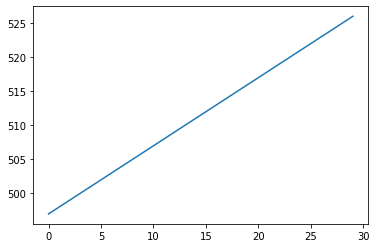

In [53]:
width,saved_idxs = get_saved_idxs_3_percent(1,10)
plt.plot(saved_idxs[:30])
# saved_idxs[]

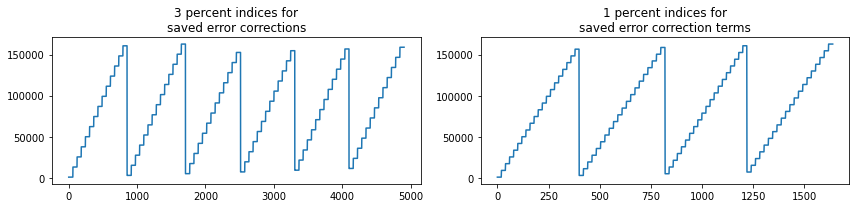

In [54]:
k = 80 # number of blocks (frames in chimeland) about 15 million

def get_saved_idxs_3_percent(n_per_save=5,k=80):
    # returns 3% of indices of most troublesome channels
    LBLOCK = 2048
    width_3 = int(LBLOCK * (0.03) * n_per_save)
    saved_data_3perc = np.arange(LBLOCK//2 - width_3//2, LBLOCK//2 + width_3//2) # width of channels
    pices = [saved_data_3perc[(i*width_3)//n_per_save:((i+1)*width_3)//n_per_save] for i in range(n_per_save)]
    saved_idxs_3 = np.concatenate([
        np.concatenate(
            [pices[s] + s*LBLOCK + i*n_per_save*LBLOCK for i in range((k+n_per_save-s-1)//n_per_save)]
        ) for s in range(n_per_save)
    ])
    return width_3, saved_idxs_3
    
# def get_saved_idxs_3_percent(n_per_save=5,k=80):
#     # returns 3% of indices of most troublesome elements in TS
#     LBLOCK = 2048
#     n_pix_3perc = 31616 # the number of pixels in eigenvalue plot that we're allowed
#     height_3 = 515 // n_per_save
#     width_3 = n_pix_3perc // height_3
#     saved_data_3perc = np.arange(LBLOCK//2 - width_3//2, LBLOCK//2 + width_3//2) # width
#     pices = [saved_data_3perc[(i*width_3)//n_per_save:((i+1)*width_3)//n_per_save] for i in range(n_per_save)]
#     saved_idxs_3 = np.concatenate([
#         np.concatenate(
#             [pices[s] + s*LBLOCK + i*n_per_save*LBLOCK for i in range((k+n_per_save-s-1)//n_per_save)]
#         ) for s in range(n_per_save)
#     ])
#     return width_3 , saved_idxs_3

def get_saved_idxs_1_percent(n_per_save=4,k=80):
    # returns 1% of indices of TS
    LBLOCK = 2048
    n_pix_1perc = 10542 # the number of pixels in eigenvalue plot that we're allowed (heigh 151)
    height_1 = 515 // n_per_save
    width_1 = n_pix_1perc // height_1
    saved_data_1perc = np.arange(LBLOCK//2 - width_1//2, LBLOCK//2 + width_1//2) 
    pices = [saved_data_1perc[(i*width_1)//n_per_save:((i+1)*width_1)//n_per_save] for i in range(n_per_save)]
    saved_idxs_1 = np.concatenate([
        np.concatenate(
            [pices[s] + s*LBLOCK + i*n_per_save*LBLOCK for i in range((k+n_per_save-s-1)//n_per_save)]
        ) for s in range(n_per_save)
    ])
    return width_1 , saved_idxs_1 

width_3 , saved_idxs_3 = get_saved_idxs_3_percent(n_per_save=6 , k=k) 
width_1 , saved_idxs_1 = get_saved_idxs_1_percent(n_per_save=4 , k=k)


plt.subplots(figsize=(12,3))
plt.subplot(121)
plt.plot(saved_idxs_3)
plt.title("3 percent indices for\nsaved error corrections")

plt.subplot(122)
plt.plot(saved_idxs_1)
plt.title("1 percent indices for\nsaved error correction terms")

plt.tight_layout()
plt.show()

In [109]:
# conjugate gradient descent with residual visualization
def conjugate_gradient_descent_verbose(B,u,x_true,x0=None,rmin=0.1,max_iter=100):
    # u is the data, B is the symmetric matrix operator (written as func)
    # solve for x : Bx = u
    # x_true is there to plot the residuals
    if type(x0) != np.ndarray: x0 = np.zeros(len(u)) # initiate first guess if not passed as arg
    x = x0.copy()
    r = u - B(x0)
    if np.sqrt(np.dot(r,r)) < rmin:
        return x
    p = r.copy()
    plt.figure(figsize=(14,4))#2.25))
    for i in range(max_iter):
        if i%1 == 0 or i<=3:
            # plot the residuals 
            rms = (x_true - x)**2
            rms = np.reshape(rms[5*LBLOCK:-5*LBLOCK],(k-10,LBLOCK)) # bad practice to hard code k=80...? I just want to write this fast
            rms_net = np.sqrt(np.mean(rms))
            rms = np.sqrt(np.mean(rms,axis=0))
            rms_smoothed = mav(rms,20)[20:-20] # chop off spoiled values
            plt.plot(rms_smoothed,color=(i/(max_iter-1),0.0,1.0-i/(max_iter-1),0.6),label="step_n={} rms_net={:.4f}".format(i,rms_net)) 
            
        
        Bp = B(p) 
        alpha = np.dot(r,r) / np.dot(p,Bp) 
        x = x + alpha * p 
        r_new = r - alpha * Bp 
        print("|r|={:.2f}".format(np.sqrt(np.dot(r,r))),end=", ") # print text for grad descent 
        if np.sqrt(np.dot(r,r)) < rmin: 
            break 
        beta = np.dot(r_new,r_new) / np.dot(r,r) 
        p = r_new + beta * p 
        r = r_new 
        
    plt.legend() 
    plt.grid() 
    plt.title("RMSE smoothed gradient steps",fontsize=16) 
    plt.tight_layout() 
    plt.savefig("RMSE_smoothed_gradient_steps_{}.png".format(np.random.randint(5))) 
    plt.show()
    return x

In [110]:
def conjugate_gradient_descent(B,u,x0=None,rmin=0.1,max_iter=100): 
    # u is the data, B is the symmetric matrix operator (written as func)
    # solve for x : Bx = u
    if type(x0) != np.ndarray: x0 = np.zeros(len(u)) # if x0 is None basically
    x = x0.copy()
#     print("Input")
#     print("\n\nx0={}".format(x)) 
#     print("\n\nu={}".format(u))
    r = u - B(x0)
    if np.sqrt(np.dot(r,r)) < rmin: 
#         print("Initial value already close enough to target value, no need for gradient descent.")
        return x
    p = r.copy()
    for i in range(max_iter): 
        Bp = B(p)
        alpha = np.dot(r,r) / np.dot(p,Bp)
        x = x + alpha * p
        r_new = r - alpha * Bp
#         print("({}) |r| = {}".format(i,np.sqrt(np.dot(r,r))))
        if np.sqrt(np.dot(r,r)) < rmin:
#             print("terminating after {} iterations,\n\
#                 remainder smaller than minimum value {}".format(i,rmin))
            break
        beta = np.dot(r_new,r_new) / np.dot(r,r)
        p = r_new + beta * p
        r = r_new
#     print("conjugate gradient computed") 
#     print("\n\nx_out={}".format(x)) 
    return x

In [120]:
def simulate_quantization_error( delta=0.5 , n_sims = 20 , k=80 , verbose=False ):
    # input param delta is the quantization step
    x_arr = [] # list of input timestream arrays
    x0_arr = [] # list of IPFB output arrays
    x1_perc_arr = [] # list of reconstructed arrays with 1% extra data
    x3_perc_arr = [] # list of reconstructed arrays with 3% extra data
    for sim in range(n_sims):
        if sim==0:print("Simulation Number __ out of {}:".format(n_sims))
        if sim%100==0: print(sim,end=" ")
        x = np.random.normal(0,1,LBLOCK*k) 
        
        d = A_quantize(x,delta) 
        # N_inv and Q_inv are diagonal matrices so we store them as 1D-arrays 
        N_inv = np.ones(len(x)) * 6 / delta**2 

        ### 3 percent of original data given as prior 
        # the noise matrix for the prior 
        prior_3 = np.zeros(len(x)) # what we know about x, information we saved 
        prior_3[saved_idxs_3] = pfb.quantize_real(x[saved_idxs_3].copy() , delta) # quantized original signal 
        
        Q_inv_3 = np.ones(len(x)) # this is a prior, change to zeros if you want zero for infinite uncertainty
#         Q_inv_3 = np.zeros(len(x))
        Q_inv_3[saved_idxs_3] = np.ones(len(saved_idxs_3)) * 12 / delta**2 # 8 bits per real number (finer std because no complex) 
        
        B_3 = lambda ts: AT(N_inv * A(ts)) + Q_inv_3 * ts # think ts===x
        u_3 = AT(N_inv * d) + Q_inv_3 * prior_3 # this is same as mult prior by var=12/delta^2
        
        ### 1 percent of original data given as prior
        # the noise matrix for the prior
        prior_1 = np.zeros(len(x)) # what we know about x, information we saved
        prior_1[saved_idxs_1] = pfb.quantize_real(x[saved_idxs_1].copy() , delta) # quantized original signal

        Q_inv_1 = np.zeros(len(x)) 
        Q_inv_1[saved_idxs_1] = np.ones(len(saved_idxs_1)) * 12 / delta**2 # 8 bits per real number

        B_1 = lambda ts: AT(N_inv * A(ts)) + Q_inv_1 * ts # think ts===x
        u_1 = AT(N_inv * d) + Q_inv_1 * prior_1

        ### Optimize CHI squared using conjugate gradient method
        # x0 is the standard IPFB reconstruction
        x0 = np.real( A_inv(d) )
        x0_weiner = np.real( A_inv_weiner(d) ) # by default the weiner threshold is set to 0.25
        
        # print("\n\nd={}".format(d)) # trace, they are indeed real
        # print("\n\nx_0={}".format(x0)) # complex dtype but zero imag componant

#         print("\nConjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)")
        if verbose: 
            plt.figure(figsize=(14,3.5))
            
            # rms virgin pfb
            rms_virgin = (x - x0)**2
            rms_virgin = np.reshape(rms_virgin[5*LBLOCK:-5*LBLOCK],(k-10,LBLOCK)) # bad practice to hard code k=80...? I just want to write this fast
            rms_net_virgin = np.sqrt(np.mean(rms_virgin))
            rms_virgin = np.sqrt(np.mean(rms_virgin,axis=0))
            rms_virgin = mav(rms_virgin,5)
            plt.semilogy(rms_virgin[5:-5],label="rmse virgin ipfb") 
            
            # rms weiner filtered pfb
            rms_weiner = (x - x0_weiner)**2
            rms_weiner = np.reshape(rms_weiner[5*LBLOCK:-5*LBLOCK],(k-10,LBLOCK)) 
            rms_net_weiner = np.sqrt(np.mean(rms_weiner))
            rms_weiner = np.sqrt(np.mean(rms_weiner,axis=0))
            plt.semilogy(rms_weiner[5:-5],label="rmse weiner filtered") 
            
            plt.grid(which="both") 
            plt.legend()
            plt.title("Log IPFB RMS residuals (smoothed)\nrmse virgin = {:.3f} rmse weiner = {:.3f}".format(rms_net_virgin,rms_net_weiner),fontsize=16) 
            plt.xlabel("Channel (n)",fontsize=13)
            plt.ylabel("RMSE",fontsize=13)
            plt.tight_layout()
            plt.savefig("Log_virgin_IPFB_RMS_residuals_weiner_{}.png".format(np.random.randint(2)))
            plt.show()
            x_out_3 = conjugate_gradient_descent_verbose(B_3,u_3,x,x0=x0_weiner,rmin=0.0,max_iter=10)
            # above set rmin to zero for it to just iterate specified amount of times
#             input("\nPress [Enter] to proceede\n") 
#         x_out_3 = conjugate_gradient_descent(B_3,u_3,x0=x0_with_zeros,rmin=1000,max_iter=25)
#         print("\n\n-----------------------------------------------------------------------------------------------")
#         print("-----------------------------------------------------------------------------------------------")
#         print("\n\n\nConjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)")
        x_out_1 = conjugate_gradient_descent(B_1,u_1,x0=x0_weiner,rmin=2000,max_iter=35)
        
        # save the arrays
        x_arr.append(x) 
        x0_arr.append(x0) 
        x1_perc_arr.append(x_out_1)
        x3_perc_arr.append(x_out_3)
        
    return np.array(x_arr), np.array(x0_arr), np.array(x1_perc_arr), np.array(x3_perc_arr)

In [121]:
delta = 0.5 # delta=0.5 is more realistic

In [122]:
# moving average smoother
def mav(x,n=5):
    y = [np.concatenate([np.zeros(i),x,np.zeros(n-i)]) for i in range(n)]
    y = np.mean(y,axis=0)
    return y[n//2:-n//2]

# Conjugate Gradient descent

Simulation Number __ out of 5:
0 

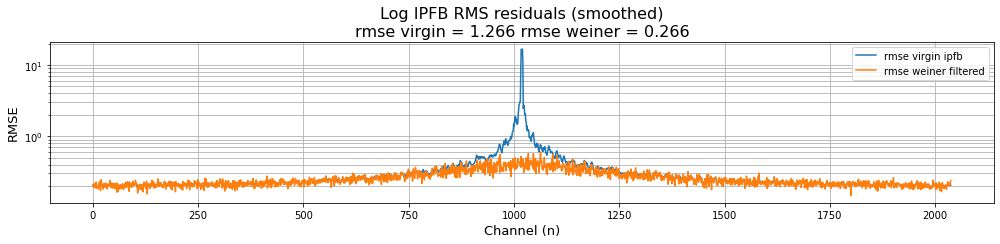

|r|=1613.77, |r|=330.79, |r|=288.22, |r|=172.51, |r|=201.23, |r|=128.43, |r|=149.72, |r|=112.50, |r|=105.20, |r|=109.73, 

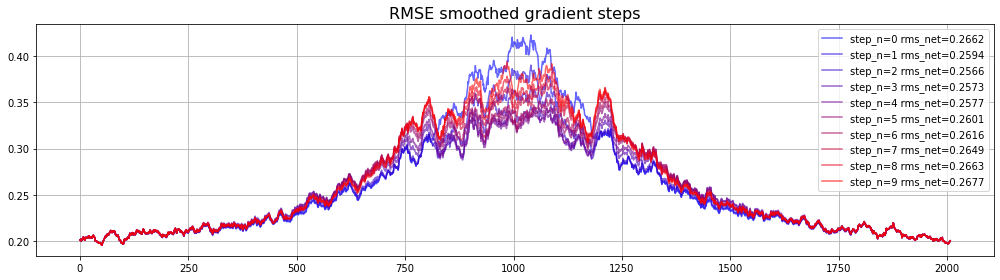

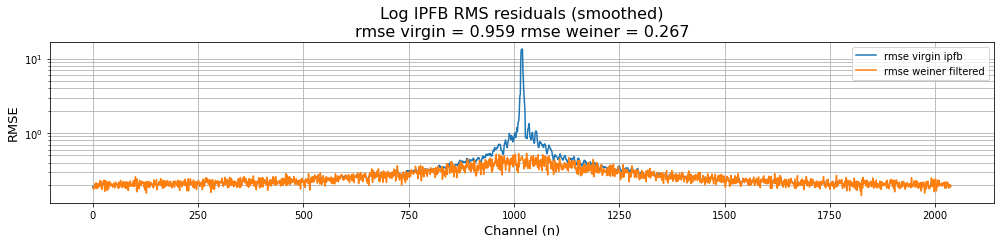

|r|=1632.55, |r|=334.75, |r|=278.01, |r|=163.49, |r|=194.30, |r|=114.04, |r|=138.60, |r|=91.40, |r|=94.65, |r|=89.51, 

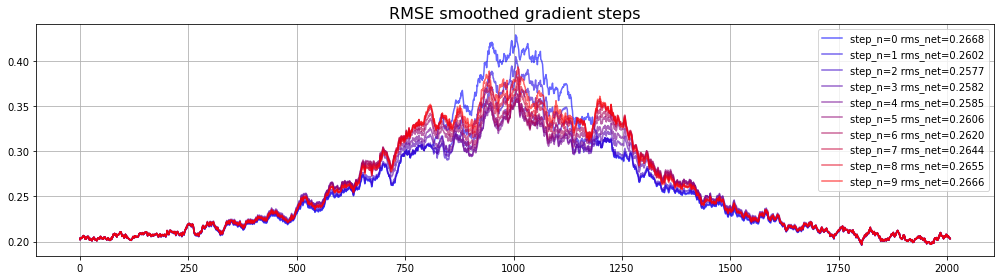

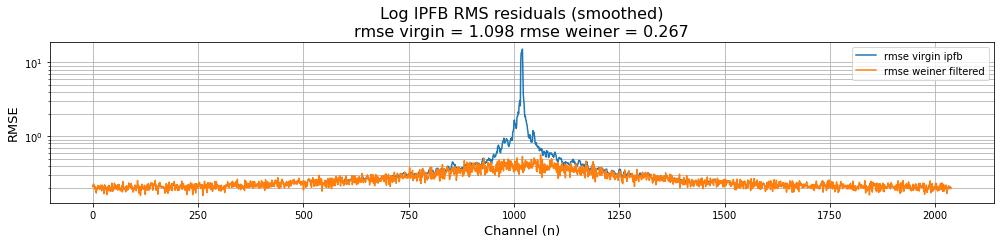

|r|=1670.02, |r|=346.84, |r|=277.79, |r|=170.00, |r|=192.44, |r|=122.75, |r|=133.39, |r|=105.63, |r|=90.04, |r|=94.93, 

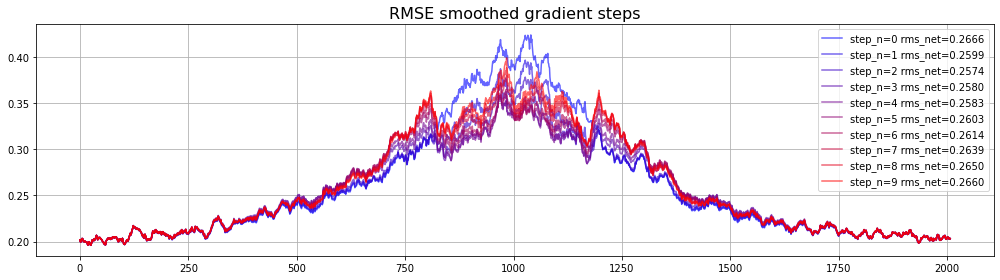

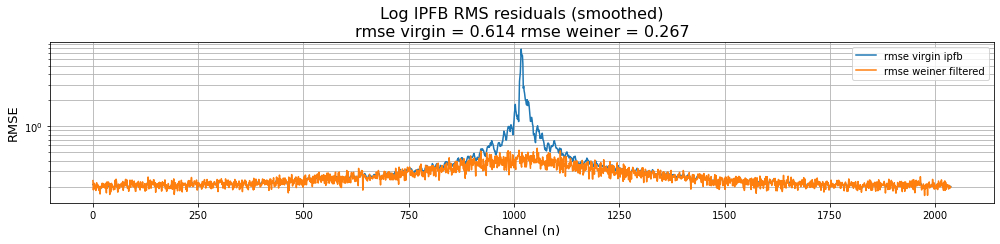

|r|=1659.88, |r|=342.14, |r|=279.99, |r|=174.07, |r|=193.33, |r|=128.75, |r|=136.22, |r|=113.46, |r|=93.88, |r|=100.96, 

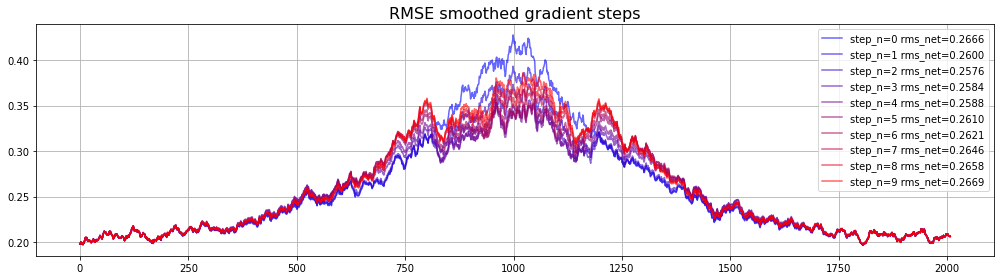

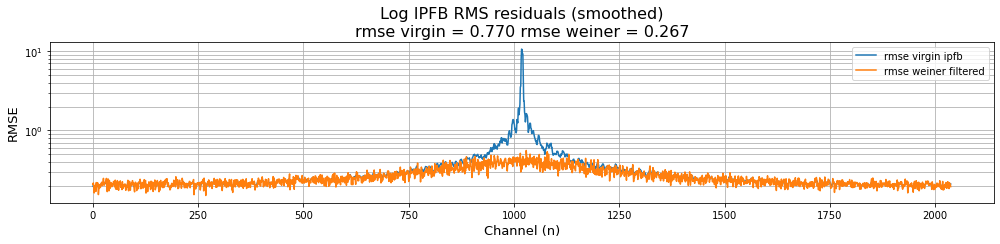

|r|=1628.78, |r|=338.35, |r|=279.47, |r|=166.27, |r|=194.19, |r|=118.56, |r|=135.09, |r|=97.83, |r|=89.29, |r|=88.50, 

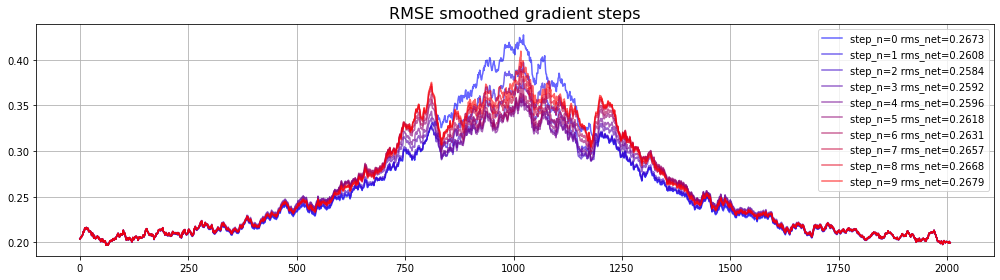

In [123]:
delta=0.5
width_1 , saved_idxs_1 = get_saved_idxs_1_percent(n_per_save = 6)
width_3 , saved_idxs_3 = get_saved_idxs_3_percent(n_per_save = 6)
_,_,_,_ = simulate_quantization_error(delta,n_sims=5, k=k, verbose=True) 

Simulation Number __ out of 5:
0 

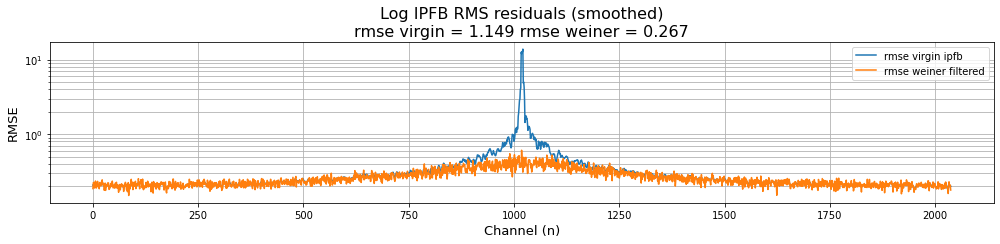

|r|=1577.16, |r|=352.18, |r|=238.17, |r|=174.13, |r|=186.74, |r|=128.28, |r|=135.47, |r|=105.10, |r|=98.40, |r|=81.86, 

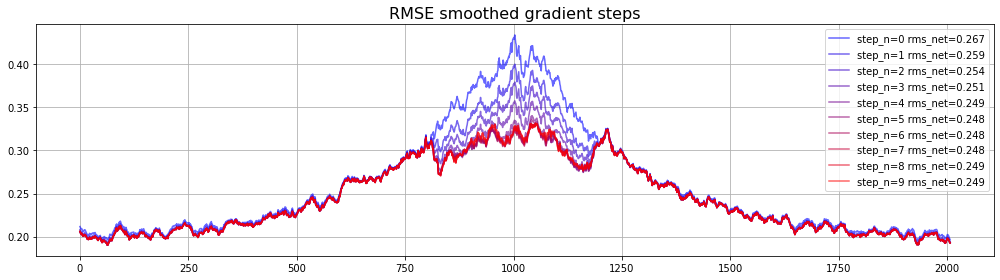

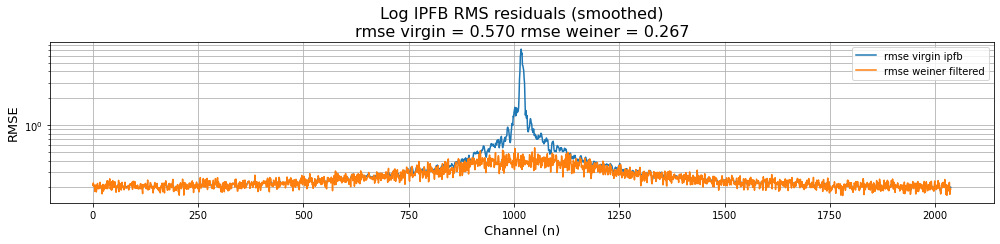

|r|=1692.05, |r|=380.60, |r|=250.70, |r|=180.82, |r|=209.61, |r|=128.76, |r|=156.27, |r|=105.05, |r|=114.91, |r|=90.47, 

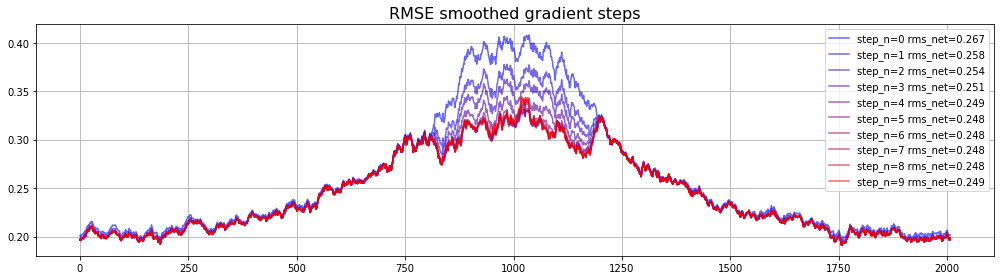

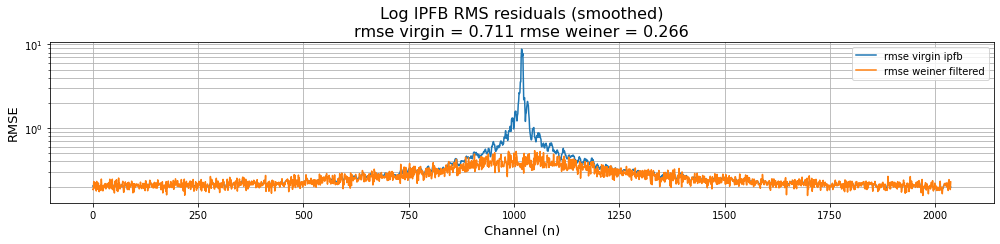

|r|=1641.58, |r|=365.51, |r|=247.61, |r|=181.35, |r|=197.11, |r|=130.16, |r|=145.03, |r|=103.81, |r|=101.08, |r|=79.38, 

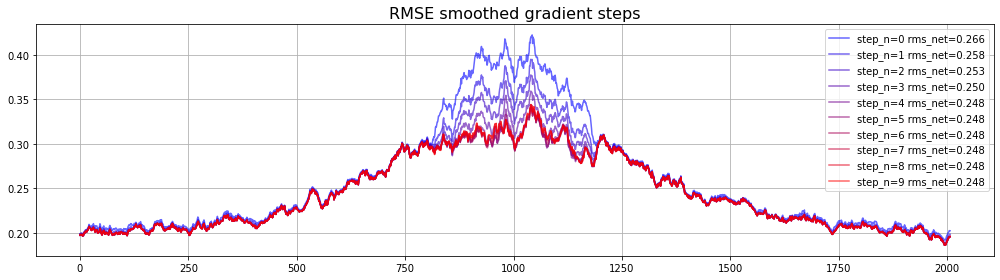

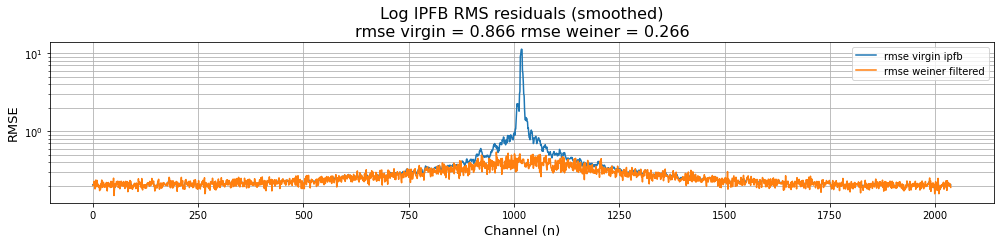

|r|=1658.16, |r|=372.15, |r|=247.22, |r|=177.47, |r|=199.17, |r|=129.74, |r|=149.92, |r|=106.58, |r|=110.80, |r|=86.61, 

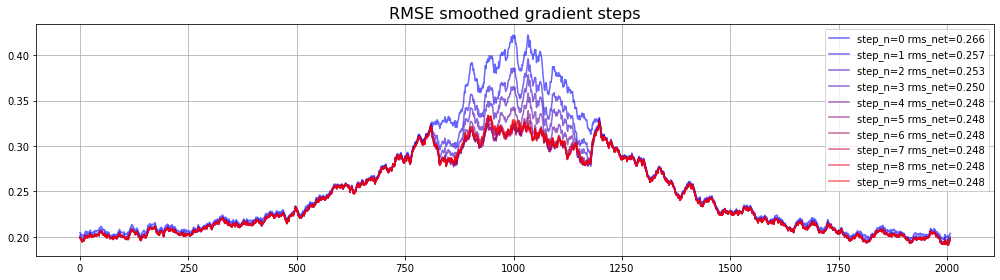

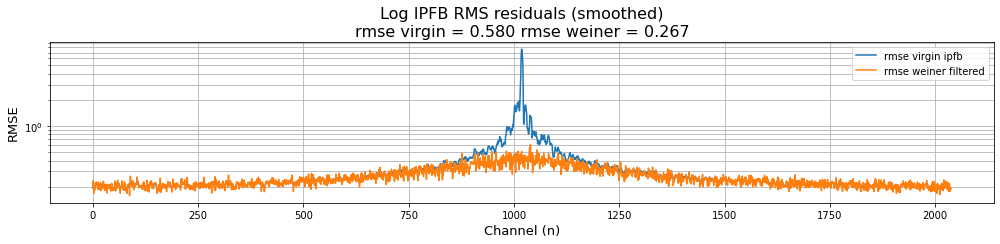

|r|=1677.52, |r|=371.21, |r|=248.65, |r|=179.61, |r|=197.94, |r|=127.96, |r|=150.78, |r|=105.46, |r|=107.79, |r|=83.47, 

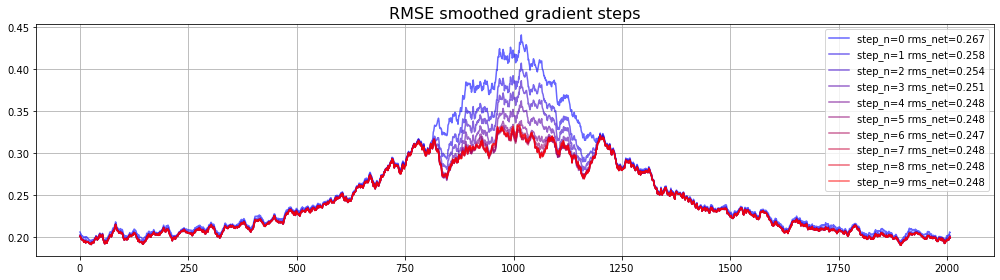

In [101]:
width_1 , saved_idxs_1 = get_saved_idxs_1_percent(n_per_save = 6)
width_3 , saved_idxs_3 = get_saved_idxs_3_percent(n_per_save = 6)
_,_,_,_ = simulate_quantization_error(delta,n_sims=5, k=k, verbose=True) 

In [ ]:
# run the simulation a bunch of times for different width / height ratios to determine what is best 
for n_per_save in range(1,4):
    width_1 , saved_idxs_1 = get_saved_idxs_1_percent(n_per_save = n_per_save)
    width_3 , saved_idxs_3 = get_saved_idxs_3_percent(n_per_save = n_per_save)

    print("\nN_PER_SAVE = {}".format(n_per_save))
    x_arr, x0_arr, x1_perc_arr, x3_perc_arr = simulate_quantization_error(delta , n_sims=1000 , k=k)
    # estimate the RMS errors
    rmse_1_perc = np.sqrt( np.mean((x1_perc_arr - x_arr)**2, axis=0) ) 
    np.save("rmse_1_perc_n_{}_delta_{}.npy".format(n_per_save,delta),np.array(rmse_1_perc))
#     rmse_1_perc_arr.append(rmse_1_perc)
    
    rmse_3_perc = np.sqrt( np.mean((x3_perc_arr - x_arr)**2, axis=0) ) 
    np.save("rmse_3_perc_n_{}_delta_{}.npy".format(n_per_save,delta),np.array(rmse_3_perc))
#     rmse_3_perc_arr.append(rmse_3_perc)


In [105]:
# load these guys, put into super array and save a copy of super array
rmse_3_perc_arr = [] 
rmse_1_perc_arr = [] 

for n_per_save in range(4,17):
    rmse_1_perc_arr.append(np.load("rmse_1_perc_n_{}_delta_{}.npy".format(n_per_save,delta)))
    rmse_3_perc_arr.append(np.load("rmse_3_perc_n_{}_delta_{}.npy".format(n_per_save,delta)))
    
rmse_1_perc_arr = np.array(rmse_1_perc_arr) 
rmse_3_perc_arr = np.array(rmse_3_perc_arr)
np.save("rmse_1_perc_4to16_delta_{}.npy".format(delta),np.array(rmse_1_perc_arr))
np.save("rmse_3_perc_4to16_delta_{}.npy".format(delta),np.array(rmse_3_perc_arr))
    

In [23]:
rmse_1_perc_arr.shape,rmse_3_perc_arr.shape

((13, 163840), (13, 163840))

In [11]:
# idx1 = np.arange(2*LBLOCK,20*LBLOCK) 
idx1 = np.arange(3*LBLOCK,len(x_arr[0]) - 3*LBLOCK)
idx2 = np.arange(51700,54700) 

plt.subplots(figsize=(20,14))
plt.subplot(421)
plt.title("Sample Gaussian Noise input Signal with sigma=1.0\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18)
plt.plot(x_arr[0][idx1],linewidth=0.7,color="k")

plt.subplot(422)
plt.title("Sample Gaussian Noise input Signal with sigma=1.0\n(Roughly) One and a half blocks",fontsize=18)
plt.plot(x_arr[0][idx2],linewidth=0.7,color="k")

plt.subplot(423) 
plt.title("Estimate for RMSE for IPFB\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_ipfb[idx1]) 

plt.subplot(424) 
plt.title("Estimate for RMSE for IPFB\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_ipfb[idx2],label="IPFB") 
plt.plot(rmse_1_perc[idx2],color="red",label="1 percent prior") 
plt.plot(rmse_3_perc[idx2],color="green",label="3 percent prior") 
plt.legend(fontsize=15) 

plt.subplot(425) 
plt.title("Estimate for RMSE for 1% and 3% extra data\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_1_perc[idx1],color="red",label="1 percent prior") 
plt.plot(rmse_3_perc[idx1],color="green",label="3 percent prior")
plt.legend(fontsize=15)

plt.subplot(426) 
plt.title("Estimate for RMSE for 1% and 3% extra data\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_1_perc[idx2],color="red",linewidth=0.5,label="1 percent prior") 
plt.plot(rmse_3_perc[idx2],color="green",linewidth=0.5,label="3 percent prior")
plt.legend(fontsize=15)

plt.subplot(427) 
plt.title("Estimate for RMSE for 3% extra data\nExcluds first 3 and final 3 blocks (large errors)",fontsize=18) 
plt.plot(rmse_3_perc[idx1],color="green",linewidth=0.5,label="3 percent prior") 
plt.legend(fontsize=15) 

plt.subplot(428) 
plt.title("Estimate for RMSE for 3% extra data\nOne and a half blocks",fontsize=18) 
plt.plot(rmse_3_perc[idx2],color="green",linewidth=0.7,label="3 percent prior") 
plt.legend(fontsize=15) 


plt.suptitle("IPFB RMSE (RMS residuals averaged over 250 runs)\n\
comparison of Quantized data with conjugate gradient chi-squared minimization.\n\
Quantization step (delta) = {}".format(delta),fontsize=25) 

plt.tight_layout() 

plt.savefig("rmse_ipfb_quantization_delta={:.2f}.png".format(delta)) 

plt.show() 

NameError: name 'x_arr' is not defined

cyan


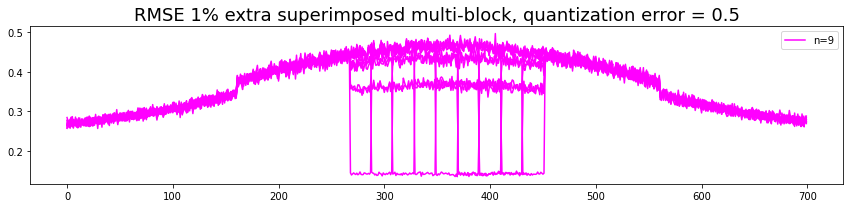

In [35]:
idx2_0 = 66200 # + LBLOCK//2
idx2 = np.arange(idx2_0,idx2_0 + 700) 


plt.subplots(figsize=(12,3))
# plt.subplot(211)
plt.title("RMSE 1% extra superimposed multi-block, quantization error = {}".format(delta),fontsize=18)
colors = ["blue","red","green","black","orange","cyan","brown","magenta","violet","indigo","yellow",
          "turquoise","lightblue","lightgreen"]
ns = [9]
lown = 4 # the smallest n in the rmse array  
for n in ns:
    rmse_1_perc = rmse_1_perc_arr[n-lown]
    print(colors[n-lown])
    plt.plot(rmse_1_perc[idx2],color=colors[n-2],label="n={}".format(n))
    for i in range(1,12):
        plt.plot(rmse_1_perc[idx2+i*LBLOCK],color=colors[n-2])
plt.legend()

# plt.subplot(212)
# plt.title("rmse 1% mean")
# for n in ns:
#     rmse_1_perc = rmse_1_perc_arr[n-2]
#     rmse_1_perc_mean = np.mean(np.array([rmse_1_perc[idx2+i*LBLOCK] for i in range(-4,12)]),axis=0)
#     plt.plot(rmse_1_perc_mean,color=colors[n-2],label="n={}".format(n))
# plt.legend()


plt.tight_layout()
plt.savefig("RMSE_superimposed_multi_block_1perc.png")
plt.show()



NameError: name 'rmse_3_perc_arr' is not defined

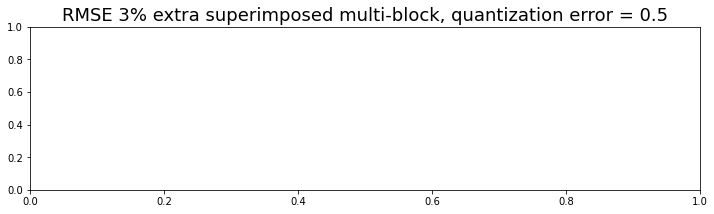

In [15]:

idx2_0 = 66200 # hand picked index, trial and error
# idx2_0 = 66200 + LBLOCK//2
idx2 = np.arange(idx2_0,idx2_0 + 700) 


plt.subplots(figsize=(12,3))
# plt.subplot(211)
plt.title("RMSE 3% extra superimposed multi-block, quantization error = {}".format(delta),fontsize=18)
colors = ["blue","red","green","black","orange","cyan","brown","magenta","violet","indigo","yellow"]
ns = [4,13]#,6,9]
dsf = 1 # downsample factor
for n in ns:
    rmse_3_perc = rmse_3_perc_arr[n-4]
    rmse_3_perc = mav(rmse_3_perc,6) # smooth with moving average
    print(colors[n-4])
    plt.plot(idx2[::dsf],rmse_3_perc[idx2[::dsf]],color=colors[n-4],label="n={}".format(n),alpha=0.5)
    for i in range(1,12):
        plt.plot(idx2[::dsf],rmse_3_perc[idx2[::dsf]+i*LBLOCK],color=colors[n-4],alpha=0.5)
plt.legend()

# plt.subplot(212)
# plt.title("rmse 3% mean")
# for n in ns:
#     rmse_3_perc = rmse_3_perc_arr[n-2]
#     rmse_3_perc_mean = np.mean(np.array([rmse_3_perc[idx2+i*LBLOCK] for i in range(-4,12)]),axis=0)
#     plt.plot(rmse_3_perc_mean,color=colors[n-2],label="n={}".format(n))
# plt.legend()


plt.tight_layout()
# plt.savefig("RMSE_superimposed_multi_block_3perc_aaa.png")
plt.show()



# Quantization error 3% correction

In [341]:
for i in os.listdir():
    if i[-4:] == ".npy":
        print(i,end="\n")

rmse_1_perc_n_7_delta_0.5.npy
rmse_1_perc_2to8.npy
rmse_3_perc_n_9_delta_0.5.npy
rmse_1_perc_n_4_delta_0.5.npy
rmse_1_perc_4to16_delta_0.5.npy
rmse_1_perc_n_14_delta_0.5.npy
rmse_3_perc_n_7_delta_0.5.npy
rmse_1_perc_n_10_delta_0.5.npy
rmse_3_perc_n_16_delta_0.5.npy
rmse_3_perc_n_12_delta_0.5.npy
rmse_3_perc_n_15_delta_0.5.npy
rmse_3_perc_n_11_delta_0.5.npy
rmse_3_perc_n_4_delta_0.5.npy
rmse_1_perc_n_13_delta_0.5.npy
rmse_1_perc_n_9_delta_0.5.npy
rmse_3_perc_n_10_delta_0.5.npy
rmse_3_perc_n_14_delta_0.5.npy
rmse_1_perc_n_8_delta_0.5.npy
rmse_1_perc_n_12_delta_0.5.npy
rmse_1_perc_n_16_delta_0.5.npy
rmse_3_perc_n_5_delta_0.5.npy
rmse_3_perc_4to16_delta_0.5.npy
rmse_1_perc_n_11_delta_0.5.npy
rmse_1_perc_9to12.npy
rmse_3_perc_n_6_delta_0.5.npy
rmse_1_perc_n_15_delta_0.5.npy
rmse_3_perc_2to12.npy
rmse_3_perc_n_13_delta_0.5.npy
rmse_virgin_ipfb.npy
rmse_3_perc_2to8.npy
rmse_1_perc_n_5_delta_0.5.npy
rmse_3_perc_n_8_delta_0.5.npy
rmse_1_perc_2to12.npy
rmse_3_perc_9to12.npy
rmse_1_perc_n_6_delta

In [342]:
# load the 3percent rmse large array
rmse_3perc_arr = np.load("rmse_3_perc_4to16_delta_0.5.npy")
rmse_virgin_ipfb = np.load("rmse_virgin_ipfb.npy")

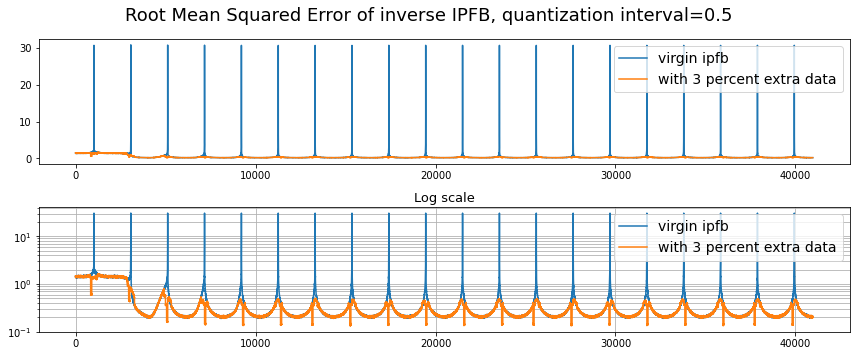

In [377]:
plt.subplots(figsize=(12,5)) 
plt.title("RMSE 3% error correction delta=0.5",fontsize=16) 

plt.subplot(211)
cut = 5 * LBLOCK
idxs4 = np.arange(cut,cut+20*LBLOCK)
plt.plot(idxs3,rmse_virgin_ipfb[idxs3],label="virgin ipfb")
plt.plot(idxs3,rmse_3perc_arr[6-4][idxs3],label="with 3 percent extra data") 
plt.legend(fontsize=14)
# plt.title("Regular",fontsize=13)

plt.subplot(212)
idxs3 = np.arange(len(rmse_virgin_ipfb))[:20*LBLOCK]
plt.semilogy(idxs3,rmse_virgin_ipfb[idxs3],label="virgin ipfb")
plt.plot(idxs3,rmse_3perc_arr[6-4][idxs3],label="with 3 percent extra data")
plt.legend(fontsize=14)
plt.title("Log scale",fontsize=13)

plt.suptitle("Root Mean Squared Error of inverse IPFB, quantization interval=0.5",fontsize=18)
plt.tight_layout()
plt.grid(which="both")

# plt.savefig("RMSE_20_epochs_inverse_IPFB_vs_3perc_error_quantization_interval_0.5___.png")
plt.show() 

# RMSE from virgin ipfb

In [135]:
try:
    rmse_virgin_ipfb = np.load("rmse_virgin_ipfb.npy")
except:
    # just get the virgin ipfb errors
    x_arr,x0_arr,_,_ = simulate_quantization_error(0.5,n_sims=5000,k=k)
    rmse_virgin_ipfb = np.sqrt( np.mean((x0_arr - x_arr)**2, axis=0) )
    np.save("rmse_virgin_ipfb_delta_{}.npy".format(delta),rmse_virgin_ipfb)

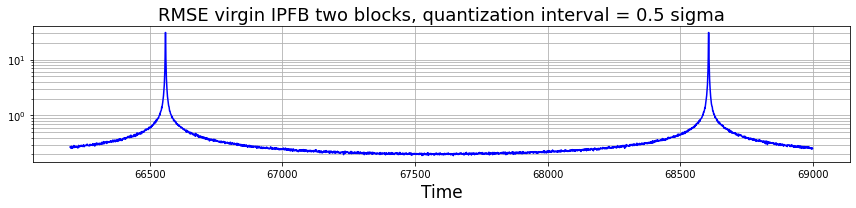

In [136]:
idx2_0 = 66200 # hand picked index, trial and error 
# idx2_0 = 66200 + LBLOCK//2 
idx2 = np.arange(idx2_0,idx2_0 + 2800) 


plt.subplots(figsize=(12,3))
# plt.subplot(211)
plt.title("RMSE virgin IPFB two blocks, quantization interval = {} sigma".format(delta),fontsize=18)
colors = ["blue","red","green","black","orange","cyan","brown","magenta","violet","indigo","yellow"]

# rmse_virgin_ipfb = mav(rmse_virgin_ipfb,1) # smooth with moving average

plt.semilogy(idx2,rmse_virgin_ipfb[idx2],color="blue",label="virgin ipfb")
# for i in range(1,12):
#     plt.semilogy(idx2, rmse_virgin_ipfb[idx2 + i*2*LBLOCK], color="blue")

# ns = [6]
# for n in ns:
#     rmse_3_perc = rmse_3_perc_arr[n-4]
#     rmse_3_perc = mav(rmse_3_perc,6) # smooth with moving average
#     print(colors[n-4])
#     plt.semilogy(idx2[::dsf],rmse_3_perc[idx2[::dsf]],color=colors[n-4],label="n={} 3%".format(n),alpha=0.5)
#     for i in range(1,12):
#         plt.semilogy(idx2[::dsf],rmse_3_perc[idx2[::dsf]+i*LBLOCK],color=colors[n-4],alpha=0.5)
# plt.legend()

# for n in ns:
#     rmse_1_perc = rmse_1_perc_arr[n-4]
#     print(colors[n-2])
#     plt.plot(idx2,rmse_1_perc[idx2],color="red",label="n={}".format(n))
#     for i in range(1,12):
#         plt.plot(idx2,rmse_1_perc[idx2+i*LBLOCK],color="red")
    
plt.grid(which="both")
plt.xlabel("Time",fontsize=17)

plt.tight_layout() 
plt.savefig("RMSE_virgin_IPFB_delta_{}.png".format(delta)) 
plt.show() 


green


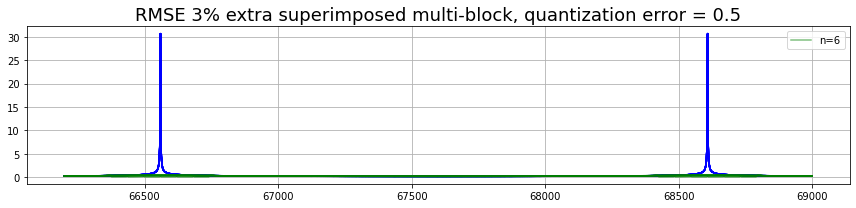

In [110]:
idx2_0 = 66200 # hand picked index, trial and error 
# idx2_0 = 66200 + LBLOCK//2 
idx2 = np.arange(idx2_0,idx2_0 + 2800) 


plt.subplots(figsize=(12,3))
# plt.subplot(211)
plt.title("RMSE 3% extra superimposed multi-block, quantization error = {}".format(delta),fontsize=18)
colors = ["blue","red","green","black","orange","cyan","brown","magenta","violet","indigo","yellow"]
    
# rmse_virgin_ipfb = mav(rmse_virgin_ipfb,1) # smooth with moving average

plt.plot(idx2,rmse_virgin_ipfb[idx2],color="blue")
for i in range(1,12):
    plt.plot(idx2, rmse_virgin_ipfb[idx2 + i*LBLOCK], color="blue")
    
ns = [6]
for n in ns:
    rmse_3_perc = rmse_3_perc_arr[n-4]
    rmse_3_perc = mav(rmse_3_perc,6) # smooth with moving average
    print(colors[n-4])
    plt.plot(idx2[::dsf],rmse_3_perc[idx2[::dsf]],color=colors[n-4],label="n={}".format(n),alpha=0.5)
    for i in range(1,12):
        plt.plot(idx2[::dsf],rmse_3_perc[idx2[::dsf]+i*LBLOCK],color=colors[n-4],alpha=0.5)
plt.legend()
    
plt.grid(which="both")

plt.tight_layout() 
# plt.savefig("RMSE_superimposed_multi_block_3perc_aaa.png") 
plt.show() 